# Progress Task 1: Prediction of wine quality

## Introduction

This progress task has the aim to predict the quality of wine based on its physicochemical properties. The dataset used in this task is the [Wine Quality Dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) from the UCI Machine Learning Repository. Credits to *P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.*

The objective of this task is to select an apropiate regression and classification model and compare them.

## Prepare environmental variables

Download the dataset and import the necessary packages.

In [11]:
%pip install ucimlrepo seaborn matplotlib scikit-learn pandas numpy pygam pydot graphviz

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [68]:
from ucimlrepo import fetch_ucirepo 
 
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
 
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 

df_wine = pd.concat([X,y], axis=1)
 
# metadata 
print(wine_quality.metadata) 

# get variable information 
print(wine_quality.variables)

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

## Exploratory Data Analysis (EDA)

In this section, a brief exploratory data analysis (EDA) will be performed on the dataset, prior to correctly pre-process it and capture the most relevant features for model training.

### Describing the dataset

In [14]:
# Check the number of instances and the number of features
print ("Shape of data:", X.shape , y.shape)

Shape of data: (6497, 11) (6497, 1)


In [15]:
# Print the first rows of the features
print("=================== Feature's First Rows ===================\n", X.head(3), "\n")

# Print the first rows of the target
print("=================== Target's First Rows ===================\n", y.head(3), "\n")

=================== Feature's First Rows ===================
    fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   

   alcohol  
0      9.4  
1      9.8  
2      9.8   

=================== Target's First Rows ===================
    quality
0        5
1        5
2        5 



In [16]:
# Check for missing values
print("=================== Null value count ===================\n",df_wine.isnull().sum(), "\n")

=================== Null value count ===================
 fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64 



In [17]:
df_wine.describe(percentiles=[])

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


Now that we have taken a look into the dataset, here's a summary:

The dataset consists of 11 continuous features, none of them with missing values. The features are: 

* `fixed_acidity`: with values ranging from 4.6 to 15.9.
* `volatile_acidity`: with values ranging from 0.12 to 1.58.
* `citric_acid`: with values ranging from 0 to 1.66.
* `residual_sugar`: with values ranging from 0.6 to 65.8.
* `chlorides`: with values ranging from 0.009 to 0.611.
* `free_sulfur_dioxide`: with values ranging from 1 to 289.
* `total_sulfur_dioxide`: with values ranging from 6 to 440.
* `density`: with values ranging from 0.99 to 1.003.
* `pH`: with values ranging from 2.74 to 4.01.
* `sulphates`: with values ranging from 0.33 to 2.
* `alcohol`: with values ranging from 8.4 to 14.9.

The target variable is:
* `quality`: is an integer variable, from 0 to 10 but in this dataset it ranges from 3 to 9.

Now that the statistical summary of the dataset has been obtained, a pairplot will be created to visualize the relationships between the features and the target variable.

### Descriptive statistics

/tmp/ipykernel_30361/3783643566.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=df_wine, palette=custom_palette)


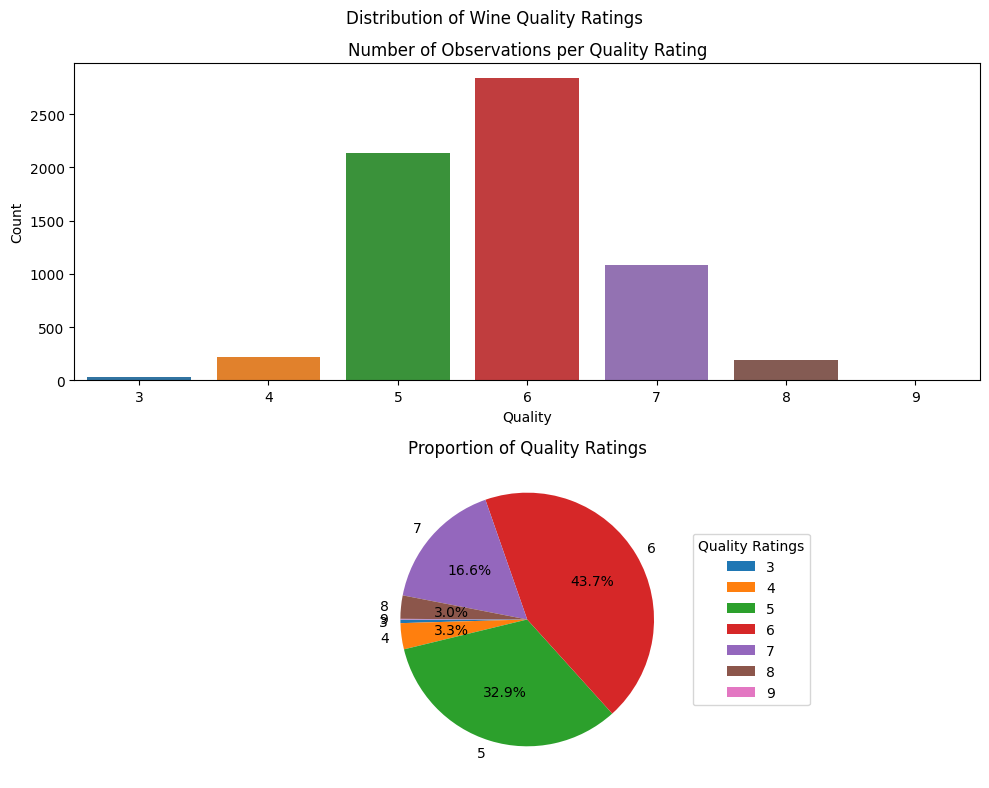

In [18]:
plt.figure(figsize=(10, 8))
plt.suptitle("Distribution of Wine Quality Ratings")
custom_palette = sns.color_palette(palette=None, n_colors = 7) # so the colors are consistent
# Bar plot
plt.subplot(2, 1, 1)
sns.countplot(x='quality', data=df_wine, palette=custom_palette)
plt.title("Number of Observations per Quality Rating")
plt.xlabel("Quality")
plt.ylabel("Count")

# Pie chart
plt.subplot(2, 1, 2)
quality_counts = df_wine['quality'].value_counts().sort_index()
plt.pie(quality_counts, labels=quality_counts.index, autopct=lambda p: f'{p:.1f}%' if p > 1 else '', startangle=180, colors=custom_palette, radius=1)
plt.legend(title="Quality Ratings", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("Proportion of Quality Ratings")
plt.tight_layout()
plt.show()

As shown in the plot, the target variable `quality` is not a balanced set. The majority of the wines have a quality of 5 or 6, with a few wines having a quality of 3 or 9. 

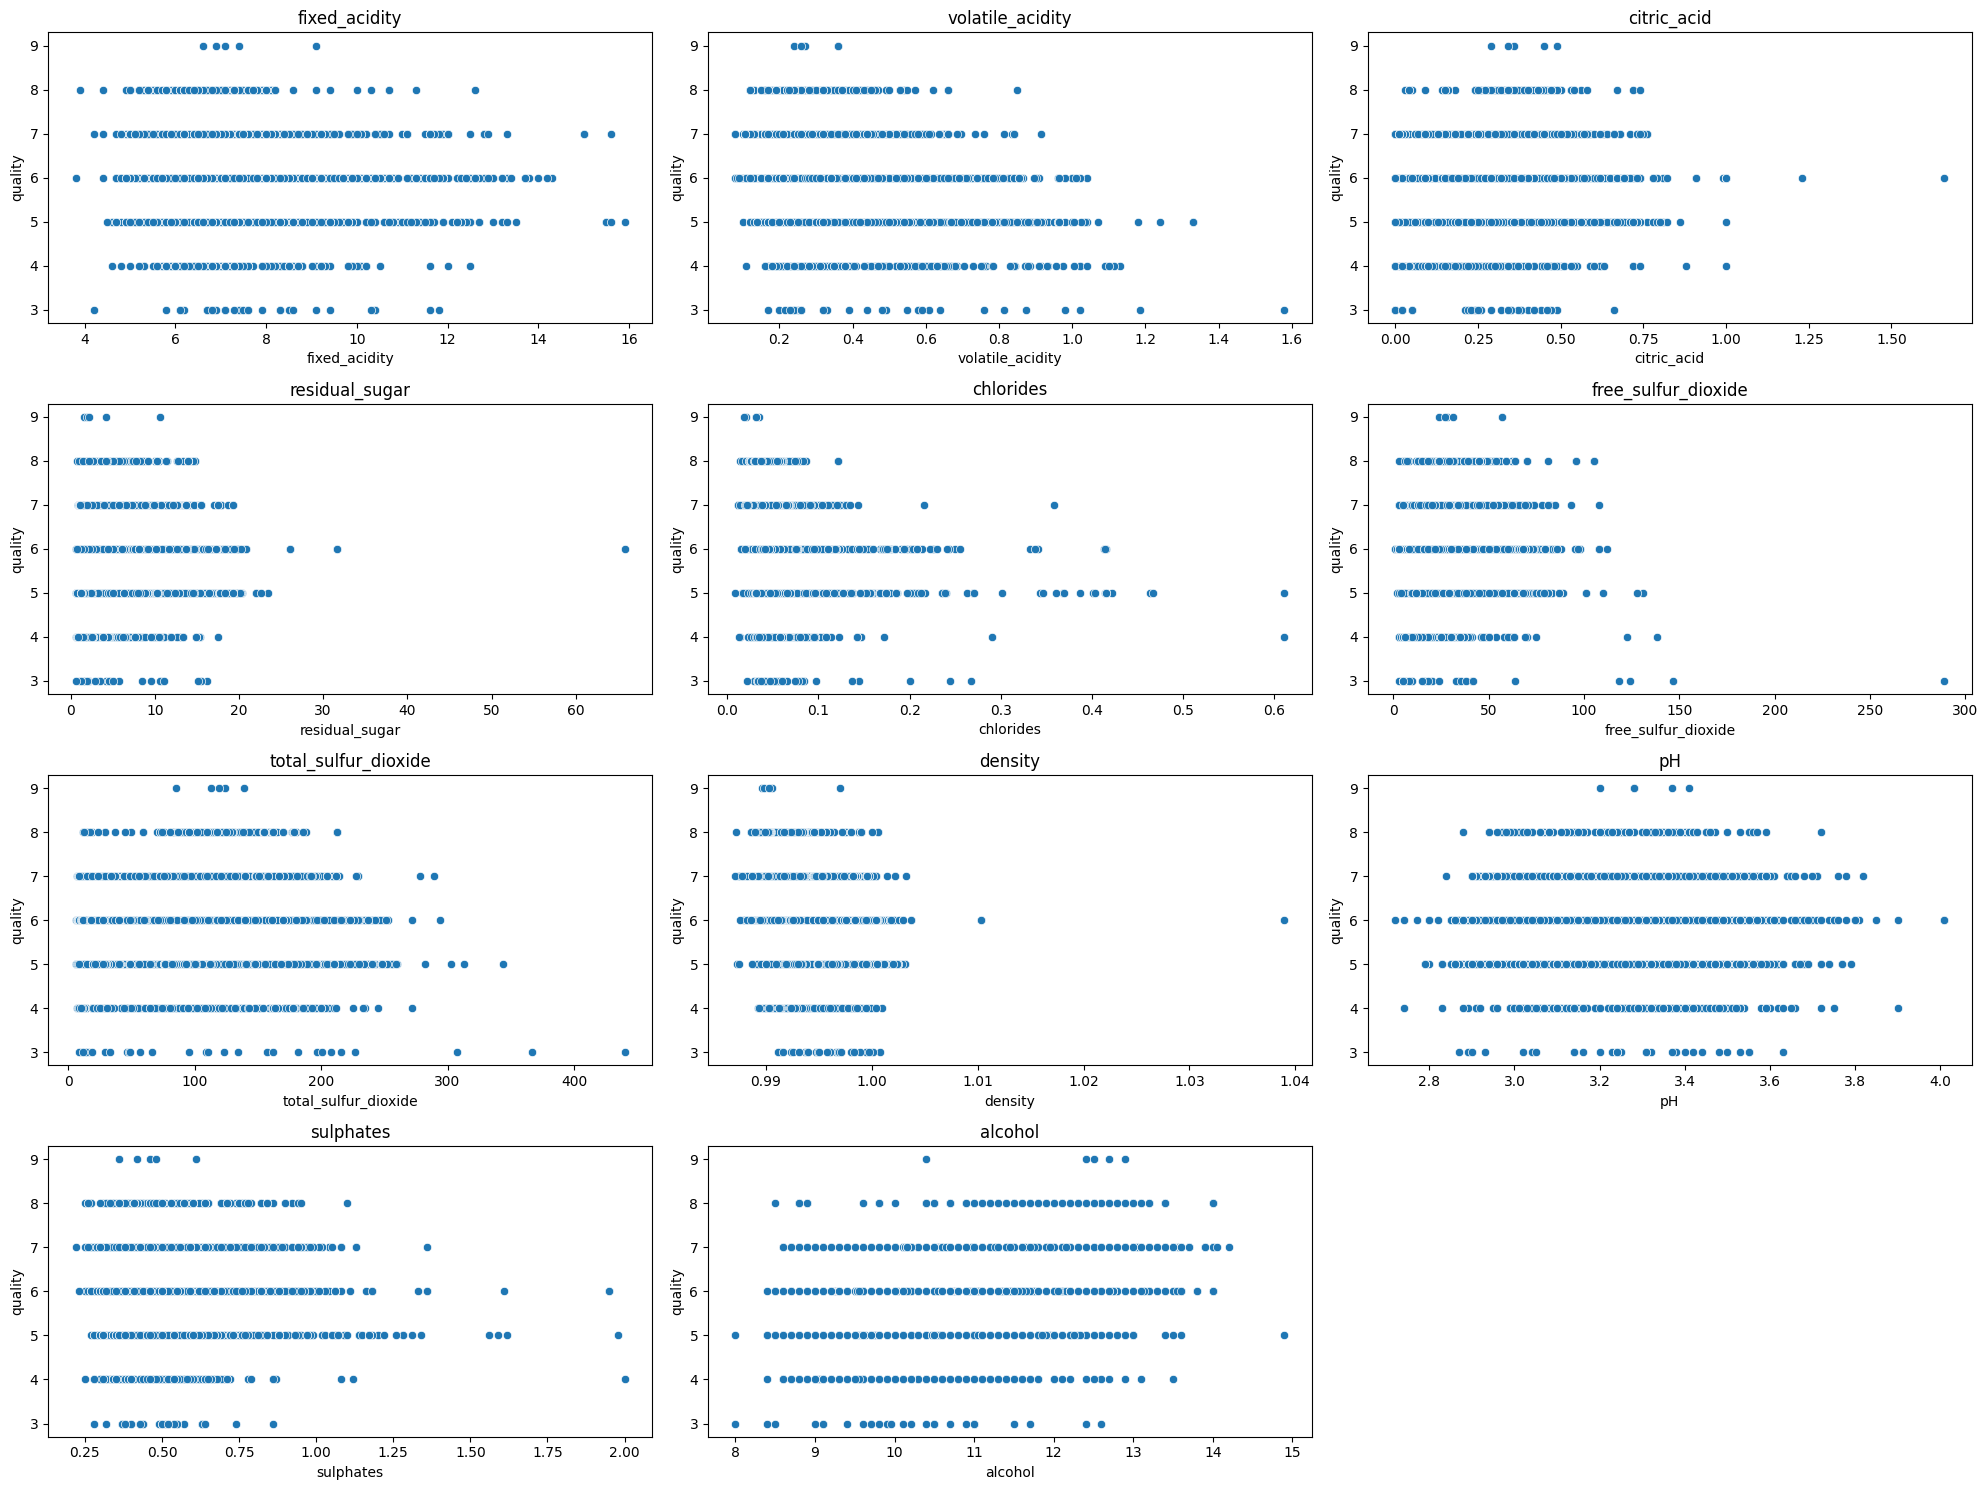

In [19]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(df_wine.columns[:-1]):
    plt.subplot(4, 3, i + 1)
    sns.scatterplot(x=feature, y='quality', data=df_wine)
    plt.title(feature)
plt.tight_layout()
plt.show()

From the pairplot, a strange data distribution can be observed. All the instances seem to be grouped by a certain value of the variable `quality`. The reason for this is that the target variable is **discrete**, so **it is treated as a categorical variable**.

Given that no direct relation with the target can be inferred from the pairplot, the next step is to create pairplots between every pair of features. Then, the dependencies between the features will be analyzed.

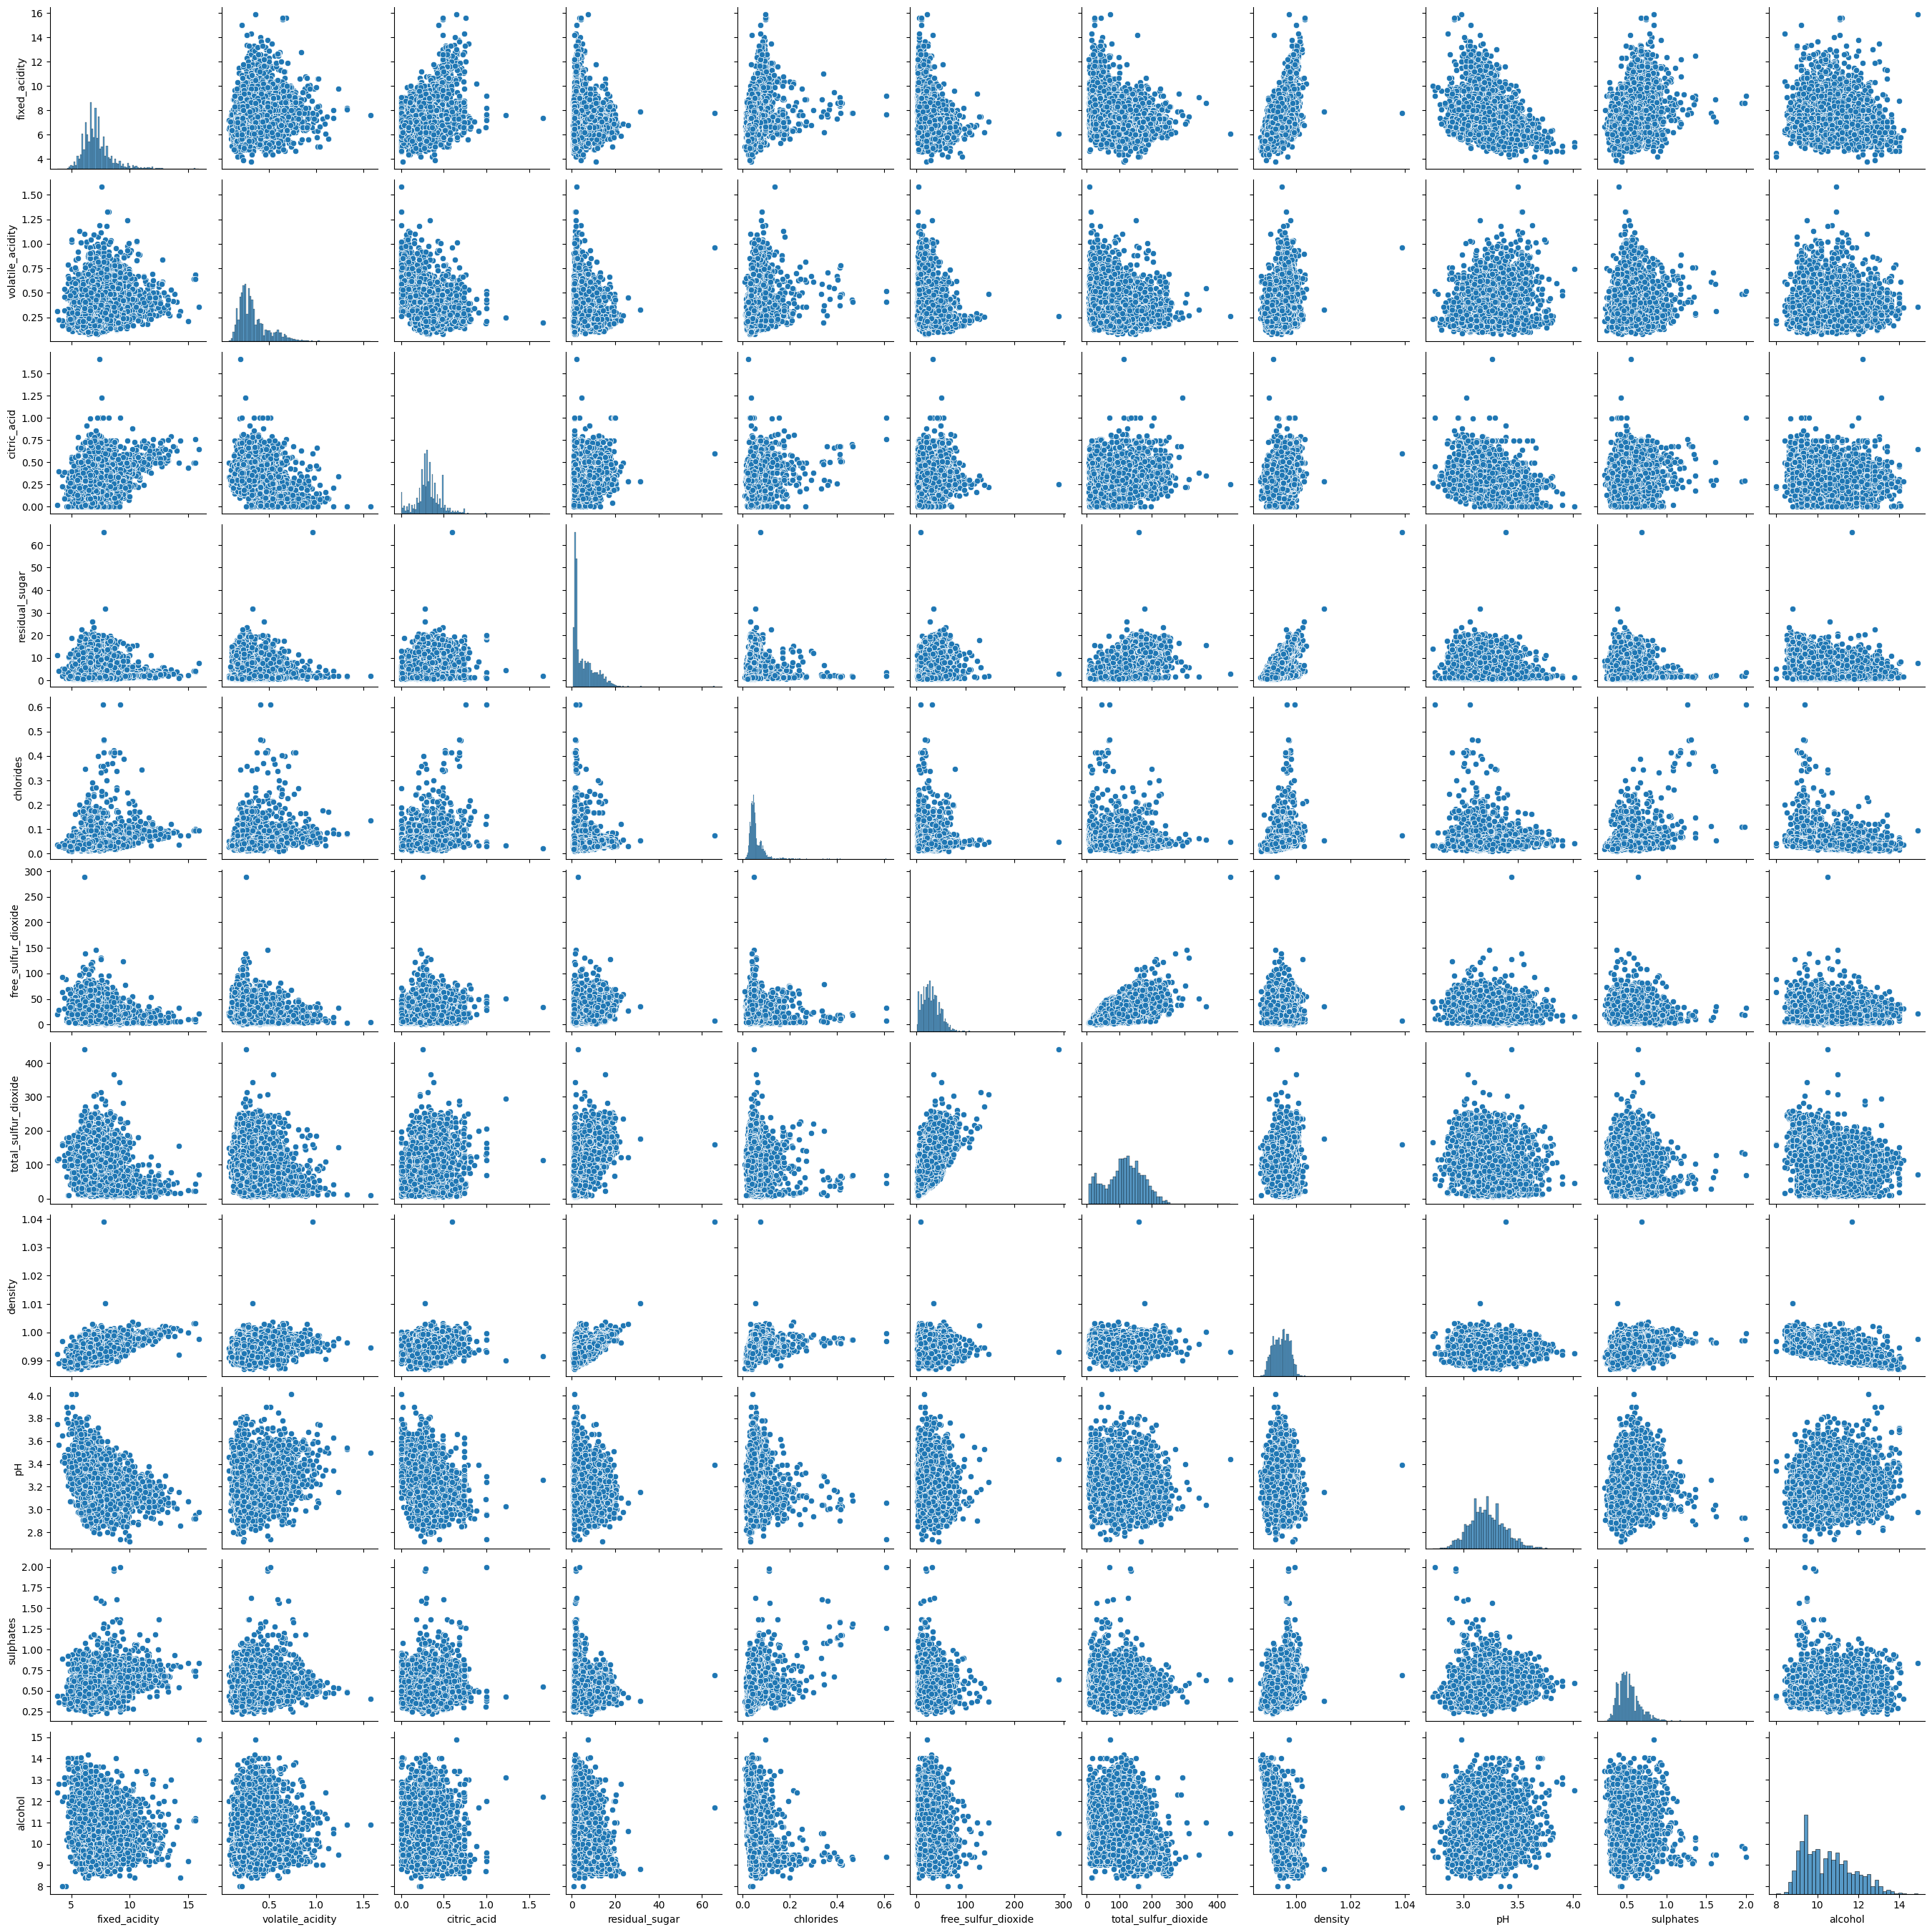

In [20]:
sns.pairplot(data = X)
plt.show()

Now, some boxplots are provided to visualize the distribution of the features for each quality value.

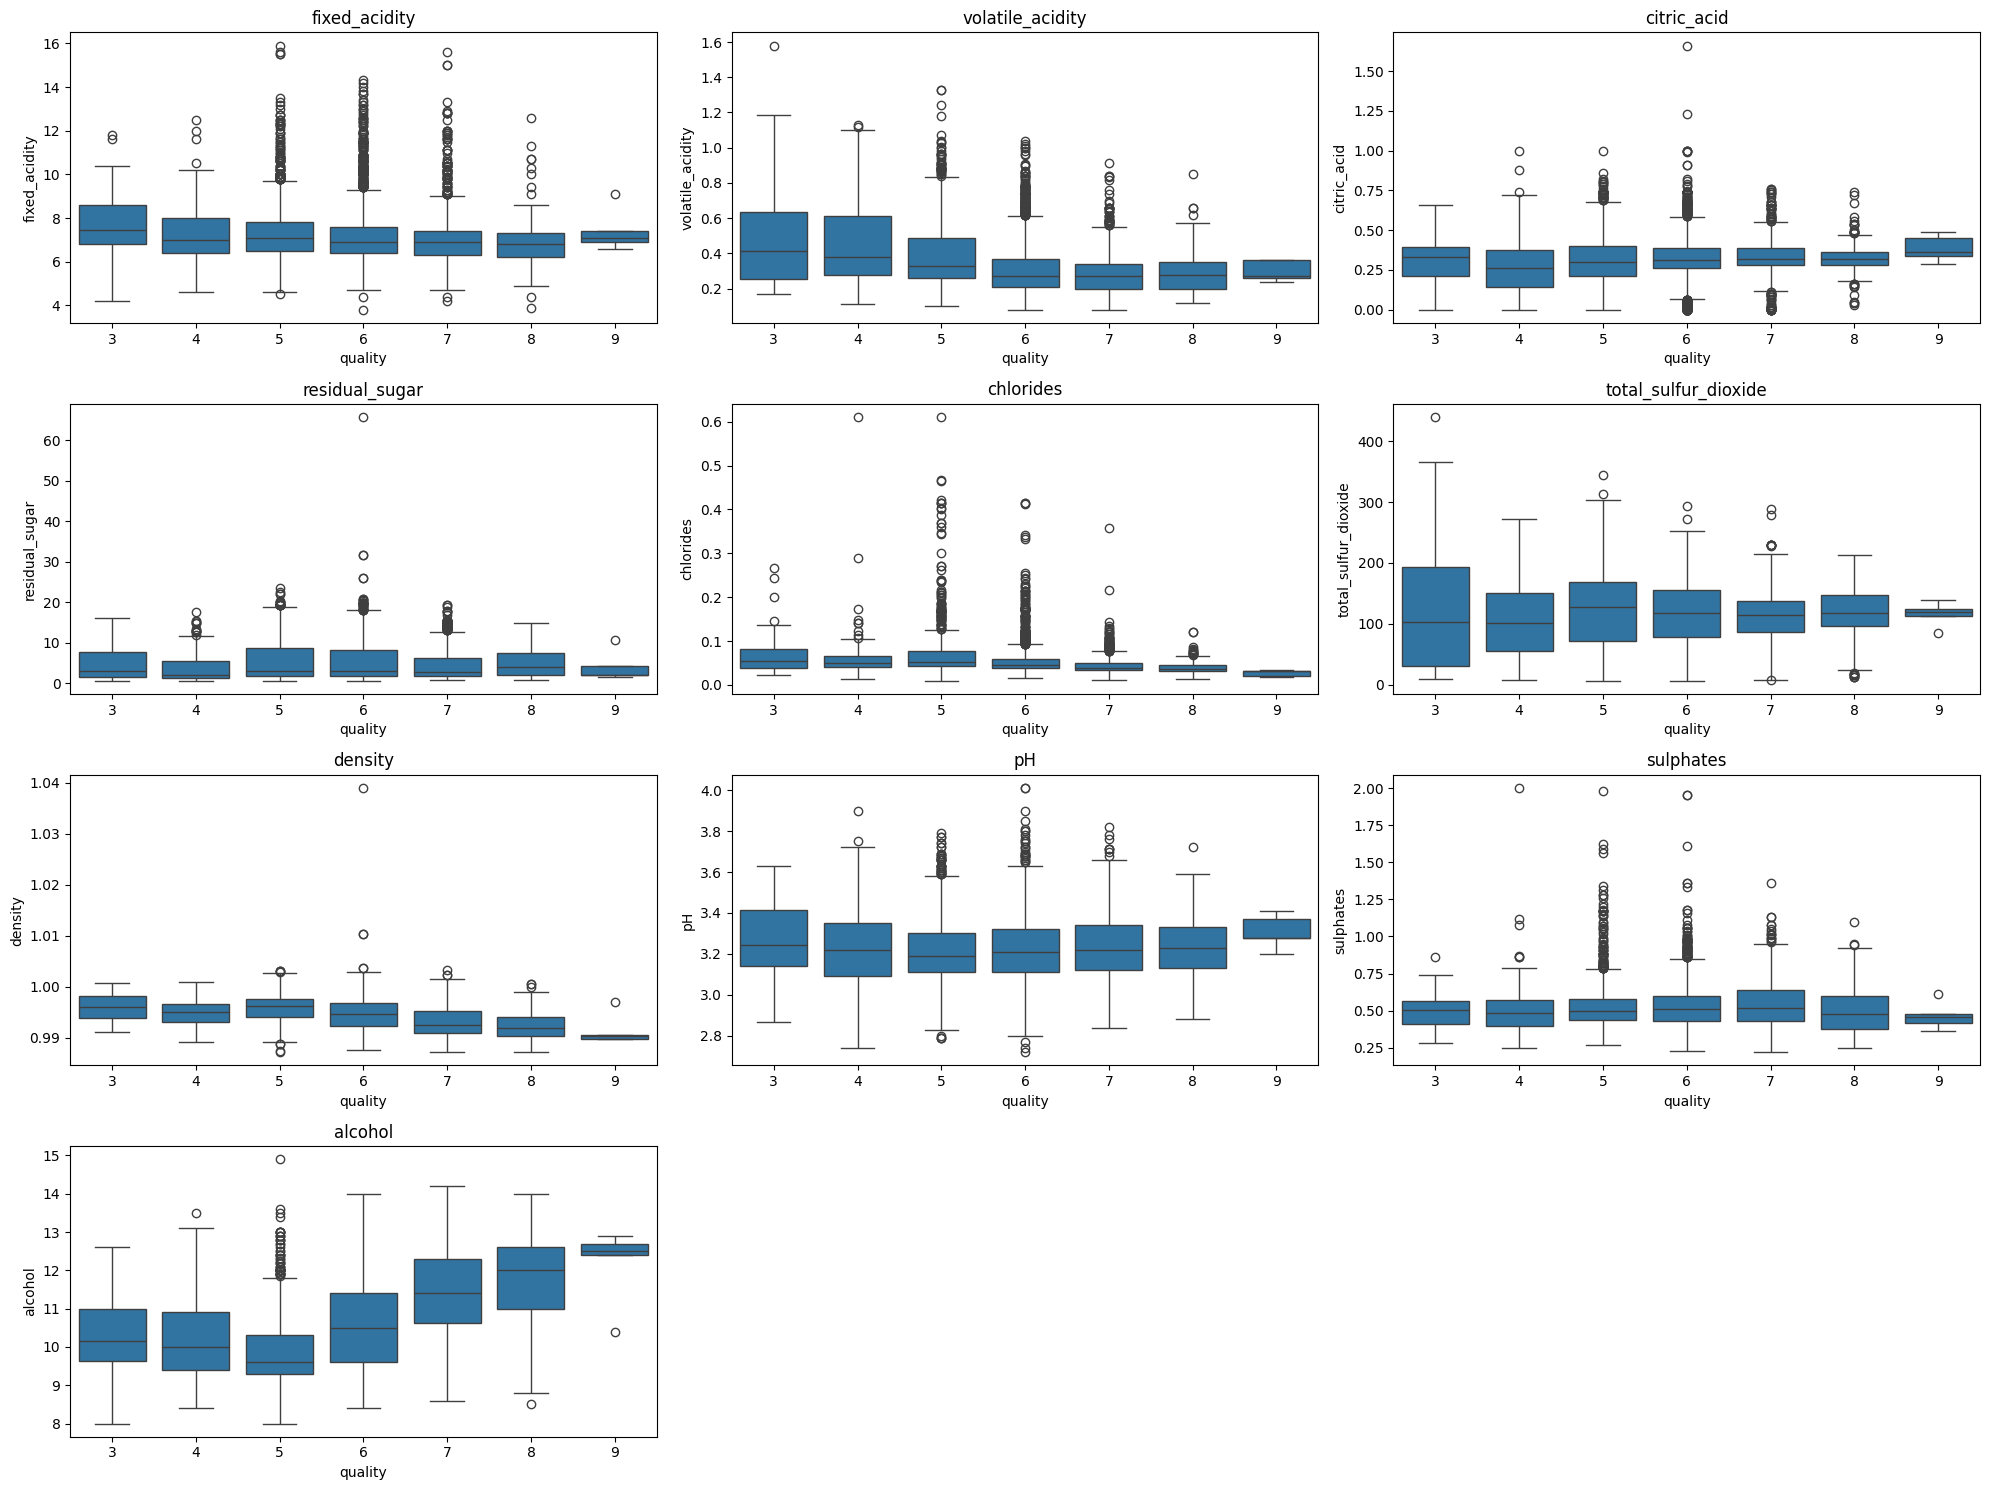

In [109]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(df_wine.columns[:-1]):
    plt.subplot(4, 3, i + 1)
    sns.boxplot(x='quality', y=feature, data=df_wine)
    plt.title(feature)
plt.tight_layout()
plt.show()

From the pairplot there are some interesting observations: 

- Fixed acidity and density seem to have a linear relationship. 
- Density seems to have a horizontal line pattern with other features, that could represent a constant value.

From there, valueable information cannot be extracted, so it is necessary to continue analyzing the dataset. 

<Axes: >

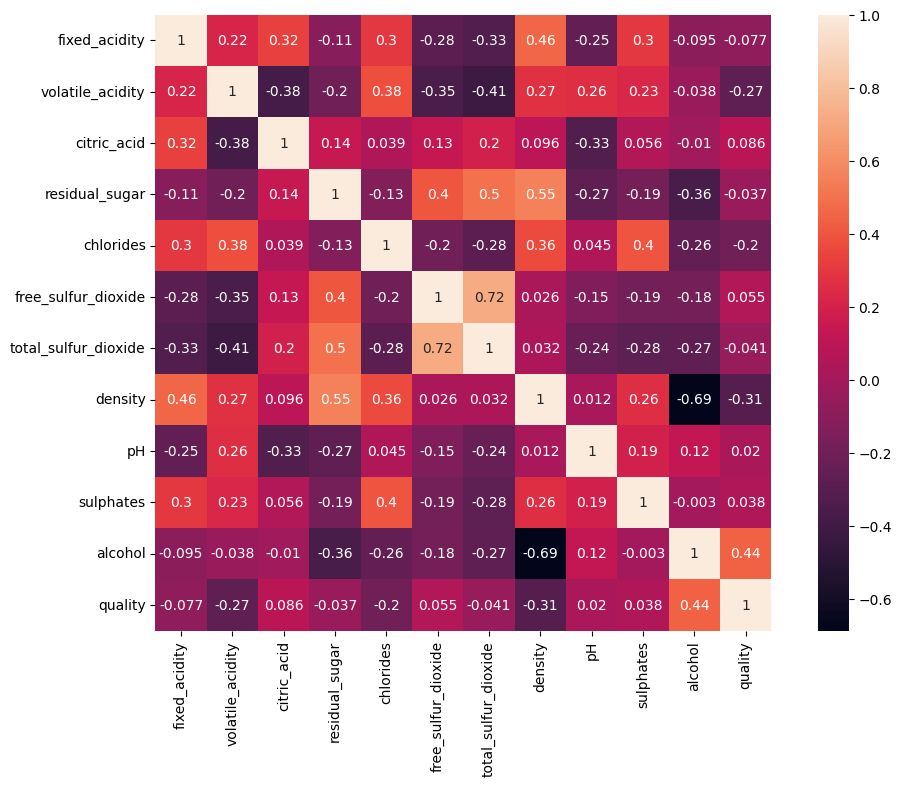

In [21]:
# Correlation matrix
plt.figure(figsize=(12, 8))
corrmat = df_wine.corr()
sns.heatmap(corrmat, square = True, annot=True)

Out from the plot, the strongest correlation can be observed between the attributes **`free_sulfur_dioxide`** and **`total_sulfur_dioxide`** (0.72). The reason for this is total sulfur dioxide includes the free sulfur dioxide, so the variable free sulfur will be removed from the dataset, as both variables represent almost the same information and this will reduce redundancy.

The second strongest correlation is between **`density`** and **`alcohol`** (-0.69). This correlation is negative, due to the fact that an increase in the alcohol graduation in wine leads to a loss of water quantity. Therefore, given that alcohol is less dense than water, the density of the wine decreases.

maybe test to remove density as it might be a constant value?

In [74]:
df_wine.drop(columns=['free_sulfur_dioxide'], inplace=True)
X.drop(columns=['free_sulfur_dioxide'], inplace=True)

/tmp/ipykernel_30361/1948943.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(columns=['free_sulfur_dioxide'], inplace=True)
